In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import jax.numpy as jnp
import optax
import jax

In [2]:
def E(theta, phi, offset=60):
    a = jnp.cos(offset)
    b = jnp.sin(offset)
    st = jnp.sin(theta)
    sp = jnp.sin(phi)
    ct = jnp.cos(theta)
    cp = jnp.cos(phi)
    c2p = jnp.cos(2 * phi)
    r_comp = st * ((ct**2) * cp * (1 - a) - (b * sp * ((st**2) * c2p + 1)))
    theta_comp = -ct * (cp * (a * (ct**2) + (st**2)) + b * sp * (1 + (st**2) * c2p))
    phi_comp = a * sp - (b * cp * ((st**2) * c2p + (ct**2)))
    # return jnp.stack([theta_comp, phi_comp], axis=0)
    return jnp.stack([r_comp, theta_comp, phi_comp], axis=0)

def T(theta, phi, offset=60):
    E_field = E(theta, phi, offset=offset)
    Et = E_field[1,:]
    Ep = E_field[2,:]
    I = (jnp.abs(Et)**2) + (jnp.abs(Ep)**2)
    Q = (jnp.abs(Et)**2) - (jnp.abs(Ep)**2)
    U = 2 * jnp.real(Et * jnp.conj(Ep))
    V = -2 * jnp.imag(Et * jnp.conj(Ep))
    return (1/2) * jnp.real(jnp.array([[I + Q,U + 1j*V], [U - 1j*V,I - Q]]))

a=.003
r=97
l=.507
c = 3e8

def Zin(freq):
    Rrad = 20 * jnp.pi**2 * ((freq * l) / c)**2
    X = (-120 / jnp.pi) * (l * freq / c) * (jnp.log(l / (2 * a)) -1)
    return Rrad + 1j*X

def Prad(freq):
    Vfwd = 1.2728094715925353
    z0 = 50 # ohms, most cables have 50 ohm impedence
    z = Zin(freq)
    tau = (z - z0) / (z + z0)
    eff = 1 - jnp.abs(tau)**2
    eta = .9 # antenna made of aluminum, so Rloss is approx 0, so eta is approx 1
    # return Pav * eff * eta # Pav is our T matrix? dont really need?
    Pfwd = (jnp.abs(Vfwd)**2) / z0
    Pin = eff * Pfwd
    return Pin * eta

# roll is 0, pitch is el, yaw is az
# actually, i think pitch is 0
def R_mat(yaw, pitch, roll):
    cy, sy = jnp.cos(yaw),   jnp.sin(yaw)
    cp, sp = jnp.cos(pitch), jnp.sin(pitch)
    cr, sr = jnp.cos(roll),  jnp.sin(roll)
    return jnp.array([
        [cy*cp,  cy*sp*sr - sy*cr,  cy*sp*cr + sy*sr],
        [sy*cp,  sy*sp*sr + cy*cr,  sy*sp*cr - cy*sr],
        [-sp,    cp*sr,             cp*cr]
    ])

def vec_to_thetaphi(v):
    # v is a 3-vector; returns radians in the healpy convention
    x, y, z = v / np.linalg.norm(v)
    theta = np.arccos(np.clip(z, -1.0, 1.0))       # 0..π
    phi   = np.arctan2(y, x)                       # -π..π
    if phi < 0:
        phi += 2*np.pi                             # 0..2π
    return theta, phi

def normalize_angles(theta, phi):
    # Accept any real theta,phi; return theta∈[0,π], phi∈[0,2π)
    theta = np.mod(theta, 2*np.pi)
    phi   = np.mod(phi,   2*np.pi)
    mask  = theta > np.pi
    if np.isscalar(theta):
        if mask:
            theta = 2*np.pi - theta
            phi   = (phi + np.pi) % (2*np.pi)
    else:
        theta[mask] = 2*np.pi - theta[mask]
        phi[mask]   = (phi[mask] + np.pi) % (2*np.pi)
    return theta, phi


def nhat(theta, phi, offset=60):
    return E(theta, phi, offset=offset)

def n_move(beam, el, az, offset=60):
    n = nhat(0,0, offset)
    nside = hp.get_nside(beam)
    rotate = R_mat(az, 0, el)
    # v = rotate.T@-n
    v = rotate@-n
    new_theta, new_phi = vec_to_thetaphi(v)
    new_theta, new_phi = normalize_angles(new_theta, new_phi)
    # if new_phi < 0:
        # new_phi += 2*jnp.pi
    new_pix = hp.ang2pix(nside, new_theta, new_phi)
    return new_pix
    # beam[new_pix] += n[0]
    # return beam
    


In [3]:
theta = np.deg2rad(np.linspace(-180, 180, 72, endpoint = False))
phi = np.deg2rad(np.linspace(-180, 180, 72, endpoint = False))
off = np.deg2rad(60)

test = E(theta, phi, off)
print(test.shape)

(3, 72)


(3, 49152)


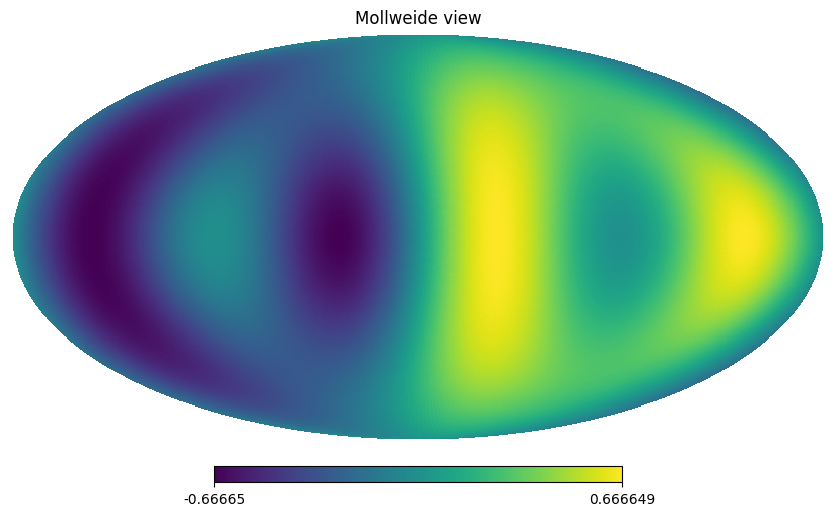

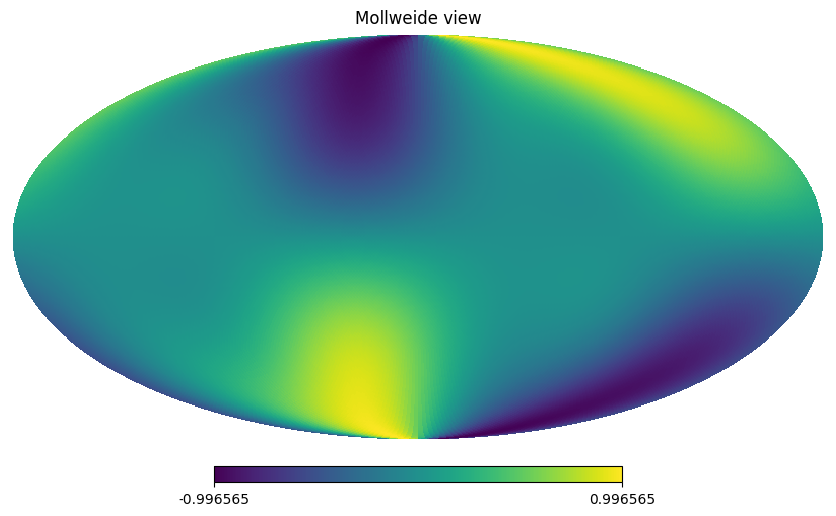

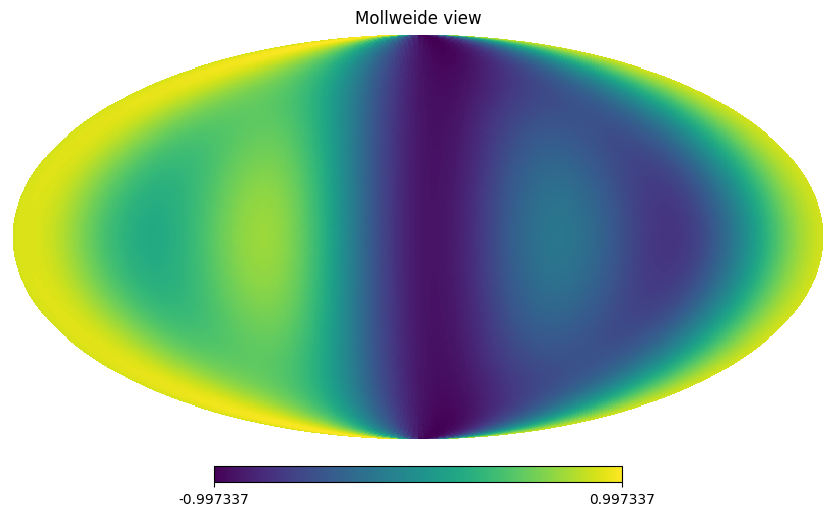

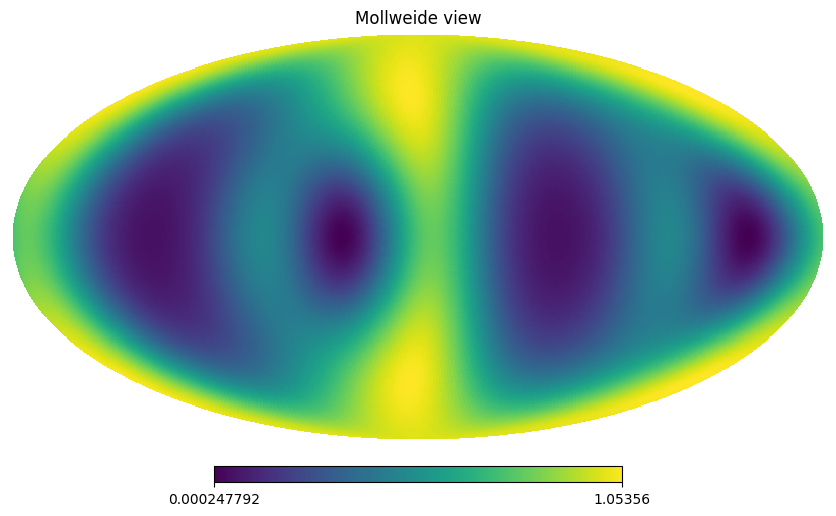

In [4]:
nside = 64
npix = hp.nside2npix(nside)
pix = np.arange(npix)
theta, phi = hp.pix2ang(nside, pix, nest=False)
E_tx = E(theta, phi, off)
# T_tx = T(theta, phi, off)
m = np.zeros((3, npix))
m += E_tx
gain_map = np.zeros(npix)
gain_map += (np.abs(E_tx[1,:])**2 + np.abs(E_tx[2,:])**2)

# m = np.zeros((npix, 2, 2))
print(E_tx.shape)
# test_point = hp.ang2pix(nside, 0, 0, nest=False)
# print(test_point)
# m[test_point] += 10
# m[-10][:,:] += np.array([[10,5],[10,10]])
hp.mollview(m[0,:])
hp.mollview(m[1,:])
hp.mollview(m[2,:])
hp.mollview(gain_map)
# hp.mollview(m[:, 0,0])
# hp.mollview(m[:, 0,1])

## Basic Attempt at Rotating Method

In [129]:
n = n_vec(np.pi/2)
rot_test = R_mat(np.pi/4,np.pi/4,0)
mat_mult = rot_test@n
print(n.shape, rot_test.shape, mat_mult.shape, mat_mult)

(3,) (3, 3) (3,) [-7.07106781e-01  7.07106781e-01  4.32978028e-17]


In [125]:
az_range_deg = np.deg2rad(np.linspace(-180.0, 180.0, 72, endpoint=False)) # orientation of the box, NOT the beam's theta and phi
el_range_deg = np.deg2rad(np.linspace(0.0, 180.0, 72, endpoint=False))
# el = []
# az = []
# el_axs = el_range_deg.copy()
# for av in az_range_deg:
    # for ev in el_axs:
        # el.append(ev)
        # az.append(av)
    # el_axs = el_axs[::-1]
el = []
az = []
loc = []
rs = []
el_axs = el_range_deg.copy()
nhat = n_vec(np.pi/2)
for av in az_range_deg:
    for ev in el_axs:
        el.append(ev)
        az.append(av)
        R = R_mat(ev, av, 0)
        Rot = R@(-nhat)
        loc.append(Rot)
        rs.append(R) # these are now the theta and phis of the beam?
    el_axs = el_axs[::-1]
loc = np.array(loc)
rs = np.array(rs)
print(loc.shape)
print(rs.shape)

beam_map = np.zeros(npix)
pos = hp.ang2pix(nside, el, az)
power = 5

    
# normal_dir = np.full((len(el)), np.pi/2)
# zero_arr = np.zeros(len(el))
# nhat = n_vec(normal_dir)
# Rot = R_mat(el, az, zero_arr)
# print(nhat.shape, Rot.T.shape)
# rotated_normal = Rot.T@nhat
# print(rotated_normal.shape)

# beam_map[pos] += power
# hp.mollview(beam_map)

(5184, 3)
(5184, 3, 3)


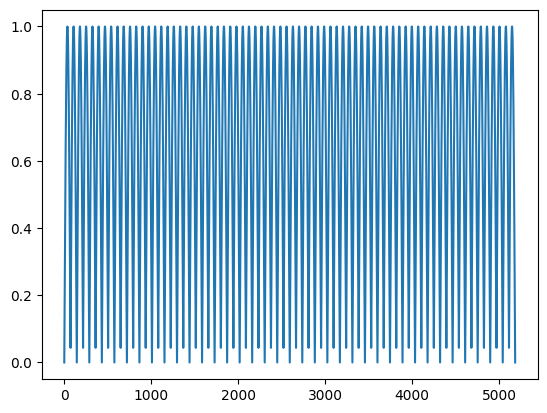

In [121]:
plt.figure()
plt.plot(loc[:,0])
# plt.plot(loc[:,1])
plt.show()

## Transforming Basis Before Rotating

In [145]:
def basis_matrix(theta, phi): # these theta and phi are the pixles on the map
    st, ct = np.sin(theta), np.cos(theta)
    sp, cp = np.sin(phi),   np.cos(phi)
    er = np.array([st*cp, st*sp, ct])
    et = np.array([ct*cp, ct*sp, -st])
    ep = np.array([-sp,   cp,    0.0])
    return np.column_stack((er, et, ep))
n = n_vec(np.pi/2)
B = basis_matrix(0, -np.pi)
print(-n)
v_xyz = B @ -n

R = R_mat(yaw=0, pitch=-np.pi, roll=0)
v_xyz_p = R @ v_xyz


vr_p, vth_p, vph_p = (B.T @ v_xyz_p)
print(vr_p, vth_p, vph_p)

[ 6.123234e-17 -1.000000e+00 -0.000000e+00]
6.123233995736766e-17 1.0 -2.4492935982947064e-16


In [146]:
az_range_deg = np.deg2rad(np.linspace(-180.0, 180.0, 72, endpoint=False)) # orientation of the box, NOT the beam's theta and phi
el_range_deg = np.deg2rad(np.linspace(0.0, 180.0, 72, endpoint=False))
el = []
az = []
loc = []
rs = []
el_axs = el_range_deg.copy()
nhat = n_vec(np.pi/2)
for av in az_range_deg:
    for ev in el_axs:
        el.append(ev)
        az.append(av)
        B = basis_matrix(ev, av)
        n_xyz = B @ -nhat
        R = R_mat(ev, av, 0)
        Rot = R@(n_xyz)
        loc.append(Rot)
        rs.append(R) # these are now the theta and phis of the beam?
    el_axs = el_axs[::-1]
loc = np.array(loc)
rs = np.array(rs)
print(loc.shape)
print(rs.shape)

beam_map = np.zeros(npix)
pos = hp.ang2pix(nside, el, az)
power = 5

    
# normal_dir = np.full((len(el)), np.pi/2)
# zero_arr = np.zeros(len(el))
# nhat = n_vec(normal_dir)
# Rot = R_mat(el, az, zero_arr)
# print(nhat.shape, Rot.T.shape)
# rotated_normal = Rot.T@nhat
# print(rotated_normal.shape)

# beam_map[pos] += power
# hp.mollview(beam_map)

(5184, 3)
(5184, 3, 3)


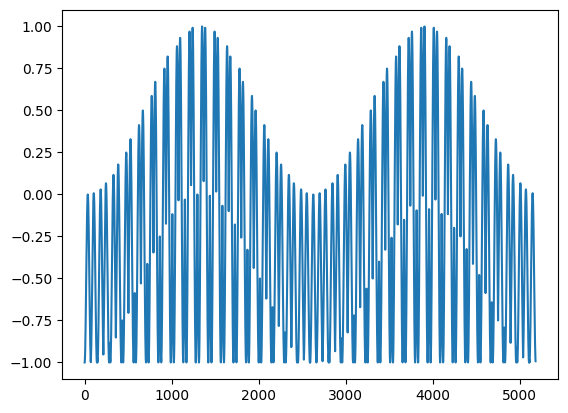

In [150]:
plt.figure()
plt.plot(loc[:,0])
plt.show()

## Using alms to Rotate

24192
24921


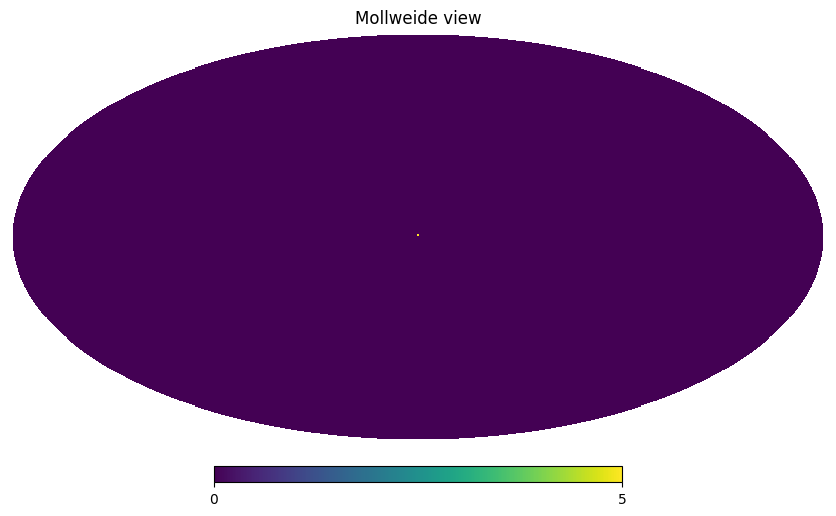

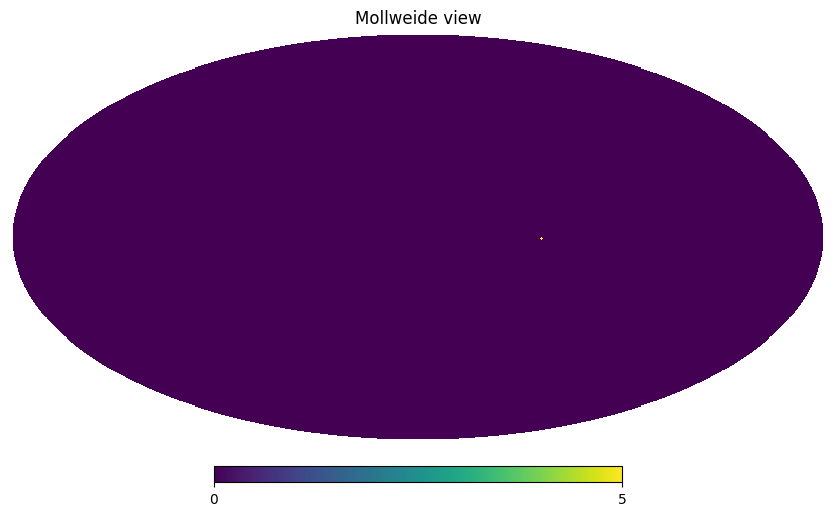

In [190]:
def rotate_scalar_map_harmonic(m, rot, deg=False):
    """
    m: scalar map (RING)
    rot: Euler angles or rotation matrix acceptable by hp.Rotator (e.g. [phi, theta, psi])
    deg: True if angles are in degrees
    """
    nside = hp.npix2nside(len(m))
    lmax  = 3*nside - 1

    # Build rotators: Rin implements the pullback m'(n)=m(R^{-1}n)
    R   = hp.Rotator(rot=rot, deg=deg)
    Rin = hp.Rotator(rot=rot, deg=deg, inv=True)

    alm    = hp.map2alm(m, lmax=lmax)
    alm_r  = Rin.rotate_alm(alm, lmax=lmax)       # rotate by the inverse
    m_rot  = hp.alm2map(alm_r, nside, lmax=lmax)

    return m_rot, R

n = [np.pi/2, 0]
beam_map = np.zeros(npix)
power = 5
power_pix = hp.ang2pix(hp.npix2nside(len(beam_map)), n[0], n[1])
print(power_pix)
# beam_map[power_pix] += power

test_el = np.array([np.pi/4, np.pi/5, np.pi/6])
test_az = np.array([np.pi/4, np.pi/5, np.pi/6])
beam_rot, R = rotate_scalar_map_harmonic(beam_map, (test_el, test_az))

n_coord = R(n[0], n[1])
rot_pix = hp.ang2pix(hp.npix2nside(len(beam_map)), n_coord[0], n_coord[1])
print(rot_pix)
beam_map[power_pix] += power
beam_rot[rot_pix] += beam_map[power_pix]
# beam_map[rot_pix] += power

hp.mollview(beam_map)
hp.mollview(beam_rot)

In [193]:
beam_map = np.zeros(npix)
for e in el:
    for a in az:
        beam_map, R = rotate_scalar_map_harmonic(beam_map, (e, a))
        n_coord = R(n[0], n[1])
        rot_pix = hp.ang2pix(hp.npix2nside(len(beam_map)), n_coord[0], n_coord[1])
        beam_map[rot_pix] += power

hp.mollview(beam_map)

KeyboardInterrupt: 

In [151]:
beam_map.shape

(49152,)

## Considering n is Just a Coordinate

/tmp/ipykernel_159879/1419838678.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freqs/1e6, 20*np.log10(s11))


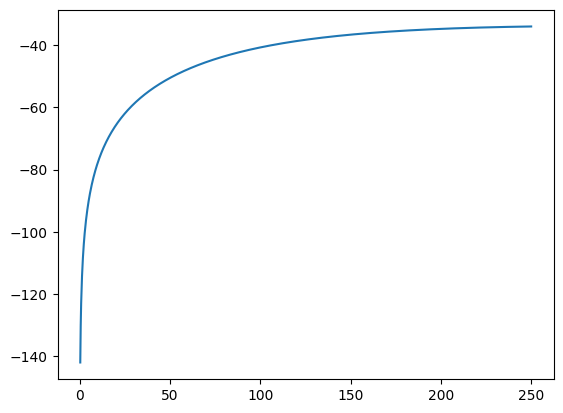

In [5]:
freqs = np.linspace(0, 250e6, 1024, endpoint=True)
s11 = Prad(freqs)
plt.figure()
plt.plot(freqs/1e6, 20*np.log10(s11))
plt.show()

24192


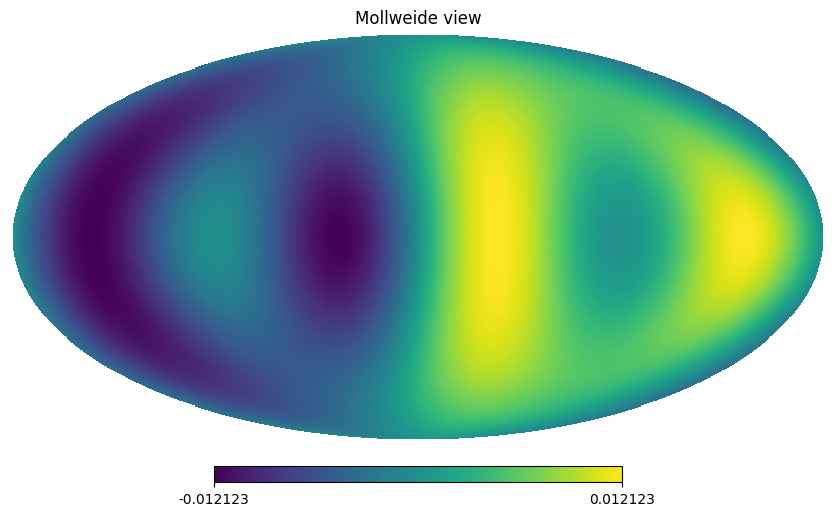

In [7]:
top = hp.ang2pix(nside, np.pi/2, 0, nest=False)
E_copy = np.copy(E_tx) * Prad(200e6)
# gain_copy = np.copy(gain_map) * Prad(200e6)
print(top)
# gain_copy[:top] *= 0
# gain_copy[top+1:] *= 0
# E_copy[:,:top] *= 0
# E_copy[:, top+1:] *= 0
# region = hp.get_all_neighbours(nside, np.pi/2,0)
# E_copy[:, region] += 5
# E_copy[:, top] += 5
# hp.mollview(E_tx[0,:])
hp.mollview(E_copy[0,:])
# hp.mollview(gain_copy)

In [260]:
beam_map = np.ones((2, npix))

top_az = -np.pi
top_el = -np.pi

top_n = top.copy()

def vis(beam, sky):
    n = top
    p = jnp.abs(jnp.dot(sky[:,n], beam[:, n]))**2 # sky will not change, beam will, apply rotation to beam n
    return p

vis(beam_map, E_copy)



Array(0.00025402, dtype=float32)

In [8]:

az_range_deg = np.deg2rad(np.linspace(-180.0, 180.0, 32, endpoint=False)) # orientation of the box, NOT the beam's theta and phi
el_range_deg = np.deg2rad(np.linspace(-180.0, 180.0, 32, endpoint=False))
el = []
az = []
el_axs = el_range_deg.copy()
for av in az_range_deg:
    for ev in el_axs:
        el.append(ev)
        az.append(av)
    el_axs = el_axs[::-1]
el = np.array(el)
az = np.array(az)

[ 0.3623725  -0.35355335 -0.8623724 ]
(1024,)
1.0


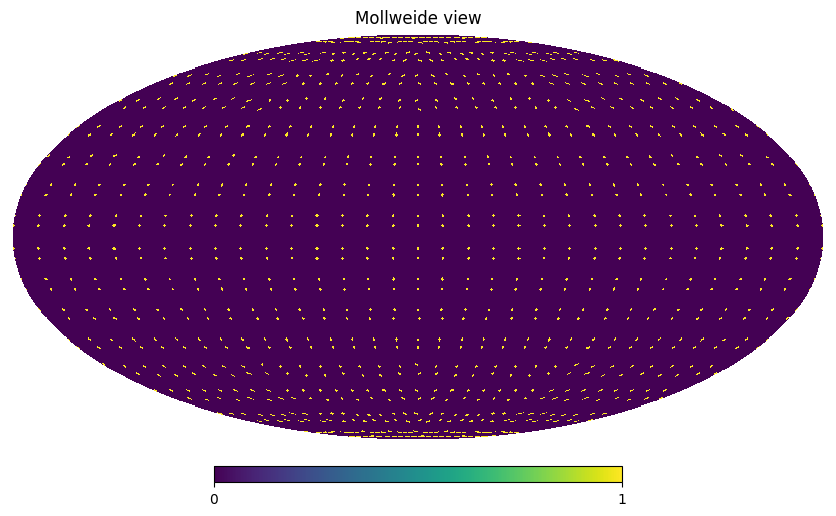

In [9]:
off = jnp.deg2rad(60)
print(R_mat(np.pi/4, np.pi/4, 0).T@nhat(0,0, off))

beam_map = np.zeros((npix))

# print(n_move(beam_map, np.pi/4, np.pi/4, offset=off))
inds = []

for i in range(el.shape[0]):
    ind = n_move(beam_map, az[i], el[i], off)
    inds.append(ind)
inds = np.array(inds)
print(inds.shape)

power = -nhat(0,0, offset=off) #* Prad(200e6)
print(power[1]**2 + power[2]**2)
beam_map[inds] +=  power[1]**2 + power[2]**2

hp.mollview(beam_map)

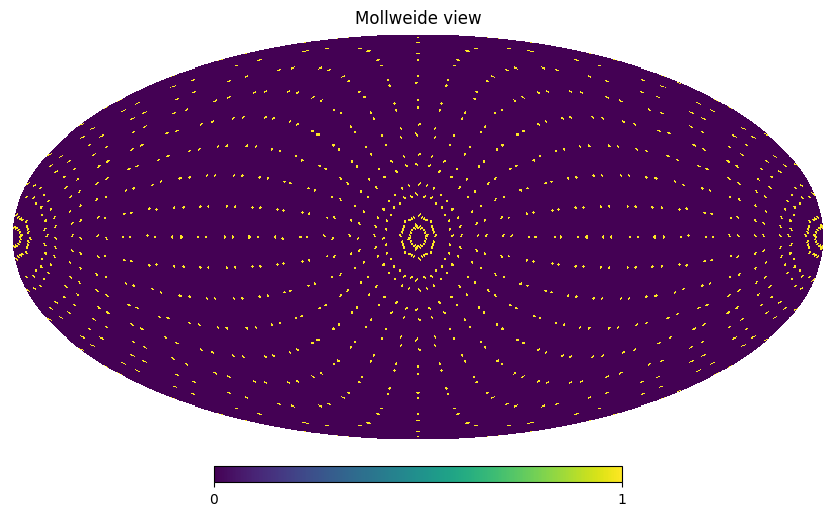

In [10]:
hp.mollview(beam_map, rot=(0,90,0))

In [469]:
beam_map.shape

(49152,)

In [22]:
def p_meas(A, offset, freq):
    E_n = nhat(0,0,offset)
    
    return jnp.abs(jnp.vdot((E_n)*Prad(freq), A))**2


def loss_fn(A, V, freq):
    off = jnp.deg2rad(60)
    model = p_meas(A, offset=off, freq=freq)
    return jnp.mean((model - V)**2)

# params = jnp.array([1.0,1.0,1.0])
optimizer = optax.adam(learning_rate=1e-2)
# opt_state = optimizer.init(params)

@jax.jit
def train_step(p, opt_state, freq, V):
    loss, grads = jax.value_and_grad(loss_fn)(p, V, freq)
    updates, opt_state = optimizer.update(grads, opt_state, p)
    p = optax.apply_updates(p, updates)
    return p, opt_state, loss
# V = 5.0

# for step in range(1000):
    # params, opt_state, loss = train_step(params, opt_state, V)
    # if step % 100 == 0:
        # print(f"step {step:4d} | loss {loss:.6f}")

# print(params)
# print(p_meas(params, jnp.deg2rad(60)))

In [23]:
def beam_finder(beam, P, el, az, offset, freq, guess):
    beam_values = jnp.zeros((3,beam.shape[0]))
    loss_values = jnp.zeros(beam_values.shape[1])
    optimizer = optax.adam(learning_rate=1e-1)
    for i in range(el.shape[0]): 
        pix = n_move(beam, el[i], az[i], offset)
        params = guess
        opt_state = optimizer.init(params)
        for step in range(1000):
            params, opt_state, loss = train_step(params, opt_state, freq, P[i])
        print(f'Finished {i}th el')
        beam_values = beam_values.at[:,pix].set(params)
        loss_values = loss_values.at[pix].set(loss)
    return beam_values, loss_values

# Power = jnp.ones_like(el) * 5
# guess = jnp.array([1.0,1.0,1.0])
# found_beam, loss_arr = beam_finder(beam_map, Power, el, az, jnp.deg2rad(60), freqs_tx[44] * 1e6, guess)
# print(found_beam.shape, loss_arr.shape)

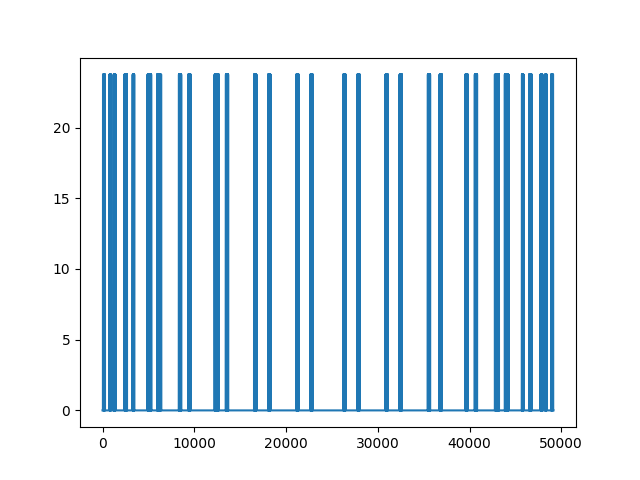

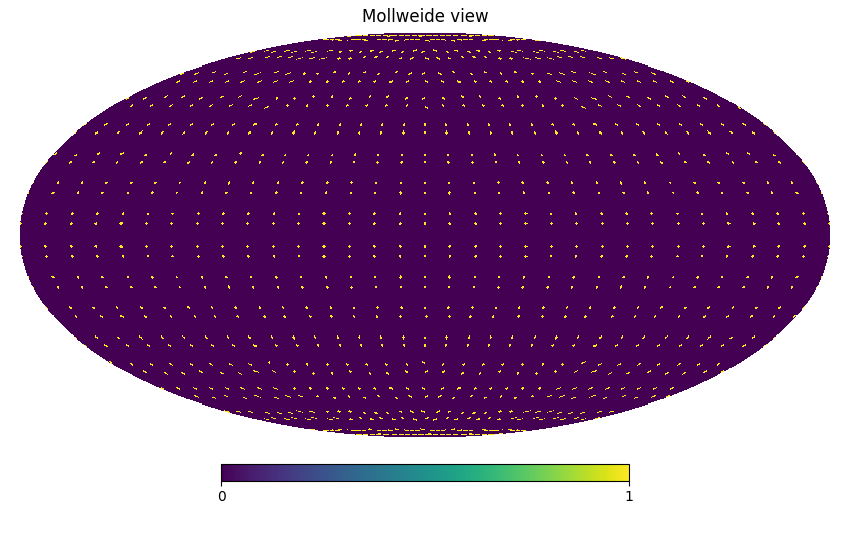

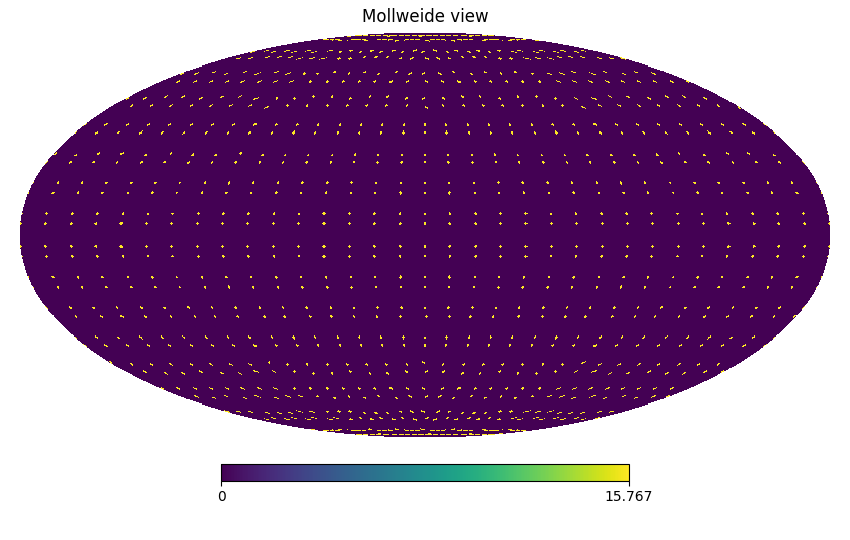

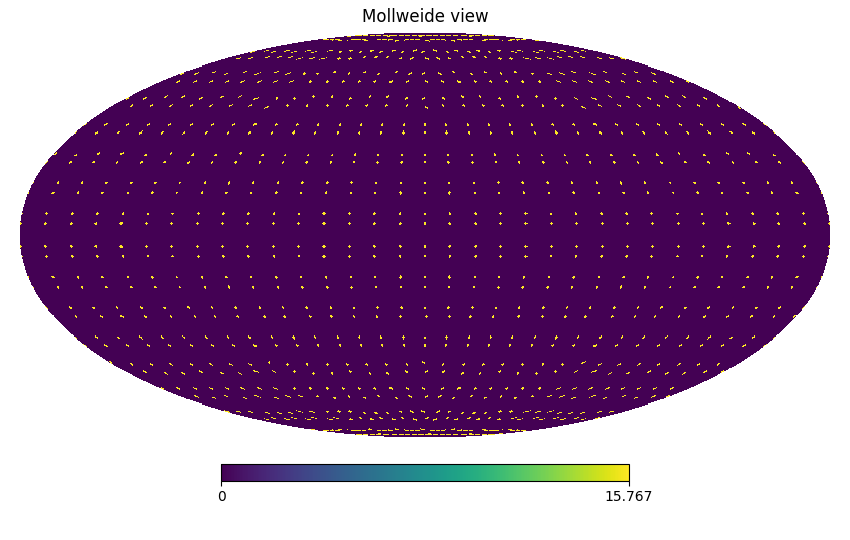

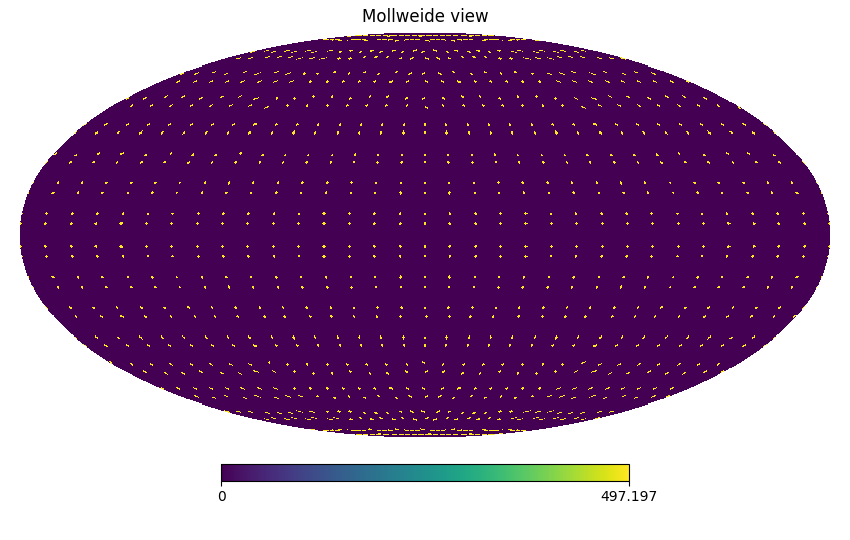

In [699]:
plt.figure()
plt.plot(loss_arr)
plt.show()

hp.mollview(found_beam[0,:])
hp.mollview(found_beam[1,:])
hp.mollview(found_beam[2,:])
hp.mollview(np.abs(found_beam[2,:])**2 + np.abs(found_beam[1,:])**2)

## Applying Above to Data

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from datetime import datetime
from dataclasses import dataclass, field
import glob
import os
import eigsep_observing as eo
import jax
import jax.numpy as jnp
import optax
from functools import partial
import matplotlib.dates as mdates

In [14]:
path = '/home/dominiv/eigsep/data/july2025/corr_data/'
def file_finder(path, date, start, end):
    files = glob.glob(path+'corr_'+date+'_*')
    start_time = datetime.strptime(date+f'_{start}', '%Y%m%d_%H%M%S')
    end_time = datetime.strptime(date+f'_{end}', '%Y%m%d_%H%M%S')
    filtered_files = []
    for file in files:
        basename = os.path.basename(file)
        try:
            timestamp_str = basename[5:-3]  # Strip 'corr_' prefix and '.h5' suffix
            file_time = datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")
            if start_time <= file_time <= end_time:
                filtered_files.append(file)
        except ValueError:
            continue
    ordered_files = sorted(filtered_files)
    print('Number of files:', len(ordered_files))
    print(f'{str(ordered_files[0])}, {str(ordered_files[-1])}')
    return ordered_files

def header_check(picos, idx, header='imu_panda'):
    if f'{header}' not in picos.keys():
        print(f'{header} not found in file:', idx)

def data_extract(files):
    data_list = []
    corr_list = []
    pico_list = []
    for i in range(len(files)):
        data, corr, pico = eo.io.read_hdf5(files[i])
        header_check(pico, i)
        data_list.append(data)
        corr_list.append(corr)
        pico_list.append(pico)
    return data_list, corr_list, pico_list

def spectra(data, ant, corr):
    data_stack = [d[ant] for d in data]
    data_stack = np.array(data_stack)
    data_stack = np.concatenate(data_stack, axis=0)

    times = [d['times'] for d in corr]
    times = np.array(times)
    times = np.concatenate(times, axis=0)
    return data_stack, times

def waterfall(data, times, freqs, logscale=True):
    dt = [datetime.fromtimestamp(ts) for ts in times]
    t_md = mdates.date2num(dt)
    plt.figure(figsize=(10,6))
    if logscale:
        plt.imshow(np.log10(data), aspect = 'auto', interpolation='none', extent = [freqs[0], freqs[-1], t_md[-1], t_md[0]], 
                   origin='upper', cmap='viridis')
    else:
        plt.imshow(data, aspect = 'auto', interpolation='none', extent = [freqs[0], freqs[-1], t_md[-1], t_md[0]], 
                   origin='upper', cmap='viridis')
    ax = plt.gca()
    ax.yaxis_date()
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Time of Day')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plotter(freqs, spec, amount=[0,0]):
    plt.figure(figsize=(10,6))
    if spec.shape[:][0] > 1 and amount != [0,0]:
        for i in range(amount[0], amount[1]):
            plt.semilogy(freqs, spec[i], label=f'Spectra index: {i}')
    else:
        plt.semilogy(freqs, spec, label='Spectra')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.show()



def pico_info(picos, device, info):
    pico = [d[device] for d in picos]
    print(len(pico))
    print(type(pico))
    print(type(pico[0]))
    pl   = [entry[info] 
            for sublist in pico 
            for entry   in sublist]
    print(type(pl), len(pl))
    return np.array(pl)


# sunday = file_finder(path, '20250720', '092000', '111200') # sunday from 9:58 pdt, battery swap at around 11:01 (12:01 in notes) (original was 9:58 to 12:13, is wrong)
# sunday = file_finder(path, '20250720', '092000', '120000') 
sunday = file_finder(path, '20250720', '121151', '134551') 
# sunday = file_finder(path, '20250720', '135203', '164239') 


data, corr, pico = data_extract(sunday)

data_stack, times = spectra(data, '2', corr) # use after friday for box data
print(data_stack.shape)
freqs = np.array(corr[0]['freqs'])
freqs_tx = freqs[::16]

Number of files: 22
/home/dominiv/eigsep/data/july2025/corr_data/corr_20250720_121310.h5, /home/dominiv/eigsep/data/july2025/corr_data/corr_20250720_134327.h5
(5280, 1024)


In [15]:
skip = 16

def gap_skip(spectra, tol=1e6):
    delete_arr = np.where(np.mean(spectra, axis=1) // tol < 1)[0]
    cut_arr = np.delete(spectra, delete_arr, axis=0)
    print(cut_arr.shape)
    return cut_arr, delete_arr

def sky_reduction(spectra, inds_skip=16):
    ncols = spectra.shape[1]
    inds = np.arange(0, ncols, inds_skip)
    valid = (inds > 0) & (inds < ncols - 1)
    v = valid.nonzero()[0]
    sky_reduced = spectra[:,inds].copy()
    sky_reduced[:, v] -= ((spectra[:,inds[v]-1] + spectra[:,inds[v]+1]) / 2)
    return sky_reduced
    
data_gap, delete_arr = gap_skip(data_stack)
reduced = sky_reduction(data_stack, skip)
norm = 1 / np.mean(reduced, axis=0, keepdims=True)
print(reduced.shape)

(4087, 1024)
(5280, 64)


(4727, 64) (4727,)
(4544, 64)
(4544, 64) (4544,)
2363


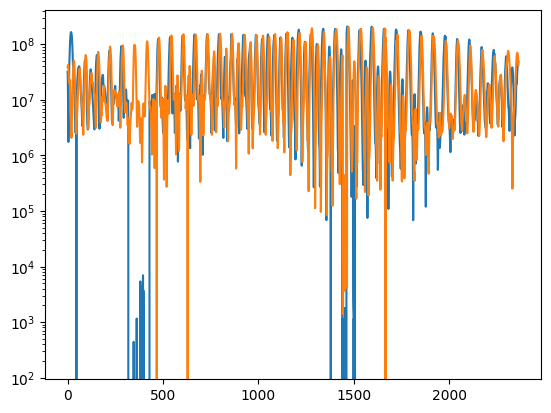

In [41]:
# i_start = 232# + 540
i_start = 171
i_stop = 4898#6000#4839
full_rot = reduced[i_start:i_stop, :]
times_rot = times[i_start:i_stop]
print(full_rot.shape, times_rot.shape)
data_gap, delete_arr = gap_skip(full_rot, tol=1e6)
skipped_time = np.delete(times_rot, delete_arr, axis=0)
print(data_gap.shape, skipped_time.shape)

half = len(full_rot[:,0])//2
print(half)
left = full_rot[:half]
right_rev = full_rot[-half:][::-1]
right = full_rot[half:]

# norm = 1 / np.mean(data_gap, axis=0, keepdims=True)

plt.figure()
# plt.semilogy(skipped_time, (data_gap[:, 40]) * norm[:,40])
# plt.semilogy((data_gap[:, 45]) * norm[:,45])
plt.semilogy((left[:, 45]))# * norm[:,45])
# plt.semilogy((right_rev[:, 45]))# * norm[:,45])
plt.semilogy((right[:, 45]))# * norm[:,45])

plt.show()

(4727, 64) (4727,)
(4544, 64)
(4544, 64) (4544,)


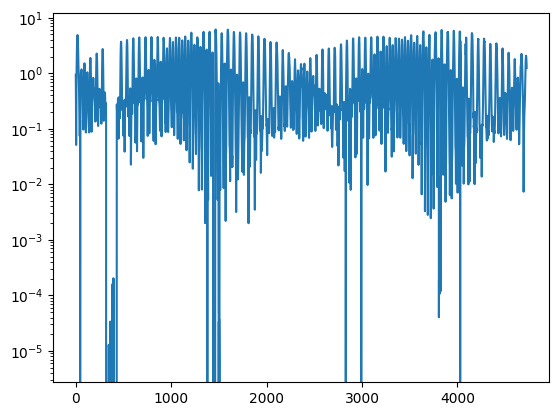

In [31]:
# i_start = 232# + 540
i_start = 171
i_stop = 4898#6000#4839
full_rot = reduced[i_start:i_stop, :]
times_rot = times[i_start:i_stop]
print(full_rot.shape, times_rot.shape)
data_gap, delete_arr = gap_skip(full_rot, tol=1e6)
skipped_time = np.delete(times_rot, delete_arr, axis=0)
print(data_gap.shape, skipped_time.shape)

half = len(full_rot[:,0]//2)
left = full_rot[:half]
right_rev = full_rot[-half:][::-1]  

# norm = 1 / np.mean(data_gap, axis=0, keepdims=True)

plt.figure()
# plt.semilogy(skipped_time, (data_gap[:, 40]) * norm[:,40])
# plt.semilogy((data_gap[:, 45]) * norm[:,45])
plt.semilogy((full_rot[:, 45]) * norm[:,45])
# plt.semilogy((left[:, 45]))# * norm[:half,45])
# plt.semilogy((right_rev[:, 45]))# * norm[-half:,45][::-1])

plt.show()

In [17]:
@dataclass
class MotorSteps:
    az_range_deg : np.ndarray
    el_range_deg : np.ndarray
    el_first : bool
    start : dict[str, int] = field(default_factory=lambda: {"az": 0, "el": 0})  # start pos in steps
    up_delay_us : dict[str, int] = field(default_factory=lambda: {"az": 2400, "el": 2400})
    dn_delay_us : dict[str, int] = field(default_factory=lambda: {"az": 300, "el": 600})
    slowdown_factor : int = 2
    slow_zone : int = 100  # in steps
    step_angle_deg : float = 1.8
    microstep : int = 1
    gear_teeth : int = 113

    def __post_init__(self):
        self.extra_delay = {k: self.slowdown_factor * v for k, v in self.dn_delay_us.items()}

        if self.el_first:
            self.axis1 = "az"  # the slow axis
            self.axis2 = "el"  # fast axis / inner loop
            self.ax1_rng = az_range_deg.copy()
            self.ax2_rng = el_range_deg.copy()
        else:
            self.axis1 = "el"
            self.axis2 = "az"
            self.ax1_rng = el_range_deg.copy()
            self.ax2_rng = az_range_deg.copy()

    def steps2deg(self, steps):
        s = steps / self.microstep / self.gear_teeth
        deg = s * self.step_angle_deg
        return float(deg)
    
    def deg_to_steps(self, degrees):
        s = degrees / self.step_angle_deg
        return int(s * self.microstep * self.gear_teeth)

    @property
    def steps(self):
        """
        Calculate the list of steps taken.

        Returns
        -------
        s : list
            Each element is a tuple of (axis, number of steps).

        """
        # steps per position
        # inner: full range every time
        nsteps_inner = self.deg_to_steps(self.ax2_rng[-1] - self.ax2_rng[0])
        # outer: one position each time  (assumes here that each position has the same step increment -- an always valid assumption in our case)
        nsteps_outer = self.deg_to_steps(self.ax1_rng[1] - self.ax1_rng[0])
        # for each outer position, take nsteps_inner steps on inner axis and then nsteps_outer steps on outer axis to get to next outer pos
        s = [(self.axis1, nsteps_outer), (self.axis2, nsteps_inner)] * self.ax1_rng.size
        # first outer step is taken into account in separate stow calculation so remove it from here
        return s[1:]

    @property
    def positions(self):
        """
        Get the arrays of postions.

        Returns
        -------
        dict
            Key is axis name, value is array of positions.
        """
        a2, a1 = np.meshgrid(self.ax2_rng, self.ax1_rng)
        a1 = a1.ravel()
        a2[1::2] = a2[1::2, ::-1]  # reverse every a1 position
        a2 = a2.ravel()
        return {self.axis1: a1, self.axis2: a2}

    def stow_time(self):
        raise NotImplementedError

    def calc_time(self, include_stow=False):
        t = 0
        for ax, ns in self.steps:
            nslow = np.minimum(2*self.slow_zone, ns)  # number of slow steps
            t += ns * (self.dn_delay_us[ax] + self.up_delay_us[ax]) + nslow * self.extra_delay[ax]
        if include_stow:
            t += self.stow_time()
        return t / 1e6

In [18]:
az_range_deg = np.linspace(-180.0, 180.0, 72, endpoint=False)
el_range_deg = np.linspace(-180.0, 180.0, 72, endpoint=False)
ms = MotorSteps(az_range_deg, el_range_deg, el_first=True)

pos        = ms.positions
az_seq     = pos['az']       # (5184,)
el_seq     = pos['el']

# rename your "times" to "scan_times"
scan_times = np.zeros(len(az_seq), float)

def step_time(ax, n_steps):
    base  = ms.up_delay_us[ax] + ms.dn_delay_us[ax]
    slow  = min(2*ms.slow_zone, n_steps)
    extra = slow * ms.extra_delay[ax]
    return (n_steps*base + extra) / 1e6

# 2) loop over scan points (not over measurements!)
for i in range(len(az_seq)-1):
    da = abs(az_seq[i+1] - az_seq[i])
    de = abs(el_seq[i+1] - el_seq[i])
    sa = ms.deg_to_steps(da) if da>0 else 0
    se = ms.deg_to_steps(de) if de>0 else 0
    scan_times[i+1] = scan_times[i] + step_time('az', sa) + step_time('el', se)

# 3) prepare your measurement‐clock
t_unix      = np.array(times[i_start:i_stop], dtype=float)   # (5760,)
# t_unix      = np.array(times_rot, dtype=float)   # (5760,)
t0          = t_unix[0]                     # or your known scan start
t_elapsed   = t_unix - t0                    # (5760,)  

# 4) interpolate az/el at each measurement time
az_aligned  = np.interp(t_elapsed, scan_times, az_seq,
                        left=az_seq[0], right=az_seq[-1])
el_aligned  = np.interp(t_elapsed, scan_times, el_seq,
                        left=el_seq[0], right=el_seq[-1])

# 5) bundle (all length 5760)
data1       = np.array(reduced[i_start:i_stop])                # (5760,1024)
# data1       = np.array(full_rot)                # (5760,1024)
aligned = {
    't_unix':   t_unix,       # original Unix times
    't_elapsed':t_elapsed,    # seconds since t0
    'az':       az_aligned,   # (5760,)
    'el':       el_aligned,   # (5760,)
    'data1':    data1,        # (5760,1024)
}


big_az = jnp.deg2rad(aligned['az'])
big_el = jnp.deg2rad(aligned['el'])

In [19]:
print(big_az.shape, reduced[i_start:i_stop][:, 44].shape, freqs_tx[44])

(4727,) (4727,) 171.875


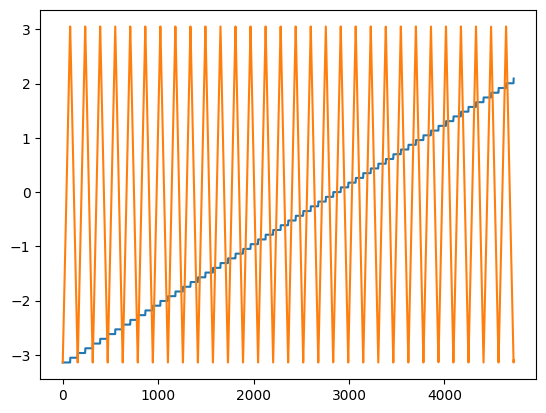

In [20]:
plt.figure()
plt.plot(big_az)
plt.plot(big_el)
plt.show()

In [24]:
Power = np.log10(reduced[i_start:i_stop][:, 44]*norm[:,44])
guess = jnp.array([1e-2, 117.0, 117.0])
beam_map = np.zeros((npix))
stop = 1000
found_beam, loss_arr = beam_finder(beam_map, Power[:stop], big_el[:stop], big_az[:stop], jnp.deg2rad(60), freqs_tx[44] * 1e6, guess)
print(found_beam.shape, loss_arr.shape)

/tmp/ipykernel_159879/1355040533.py:1: RuntimeWarning: divide by zero encountered in log10
  Power = np.log10(reduced[i_start:i_stop][:, 44]*norm[:,44])
/tmp/ipykernel_159879/1355040533.py:1: RuntimeWarning: invalid value encountered in log10
  Power = np.log10(reduced[i_start:i_stop][:, 44]*norm[:,44])


Finished 0th el
Finished 1th el
Finished 2th el
Finished 3th el
Finished 4th el
Finished 5th el
Finished 6th el
Finished 7th el
Finished 8th el
Finished 9th el
Finished 10th el
Finished 11th el
Finished 12th el
Finished 13th el
Finished 14th el
Finished 15th el
Finished 16th el
Finished 17th el
Finished 18th el
Finished 19th el
Finished 20th el
Finished 21th el
Finished 22th el
Finished 23th el
Finished 24th el
Finished 25th el
Finished 26th el
Finished 27th el
Finished 28th el
Finished 29th el
Finished 30th el
Finished 31th el
Finished 32th el
Finished 33th el
Finished 34th el
Finished 35th el
Finished 36th el
Finished 37th el
Finished 38th el
Finished 39th el
Finished 40th el
Finished 41th el
Finished 42th el
Finished 43th el
Finished 44th el
Finished 45th el
Finished 46th el
Finished 47th el
Finished 48th el
Finished 49th el
Finished 50th el
Finished 51th el
Finished 52th el
Finished 53th el
Finished 54th el
Finished 55th el
Finished 56th el
Finished 57th el
Finished 58th el
Finishe

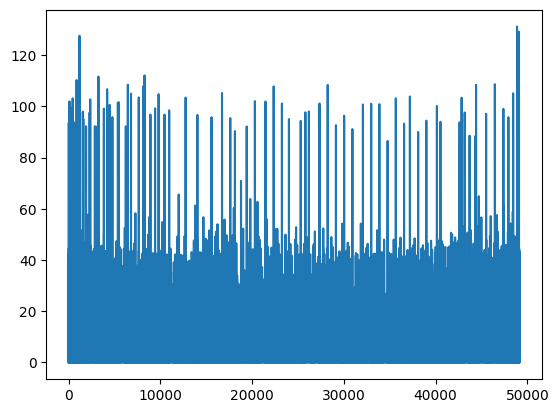

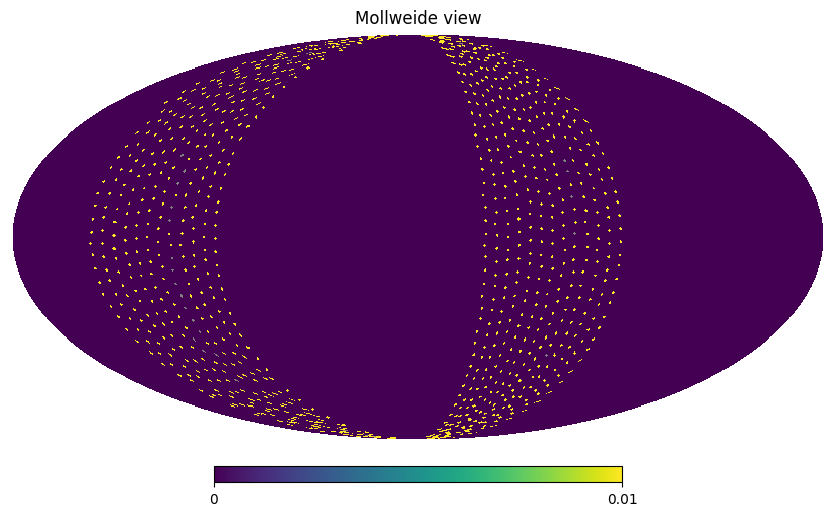

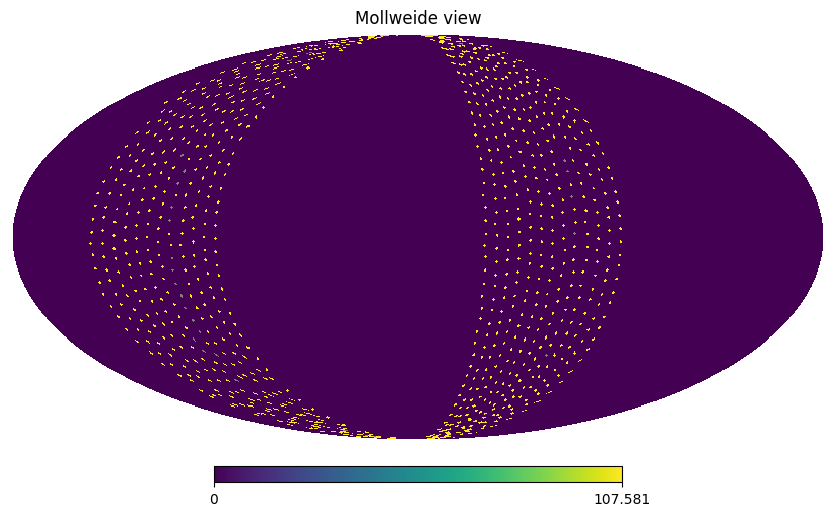

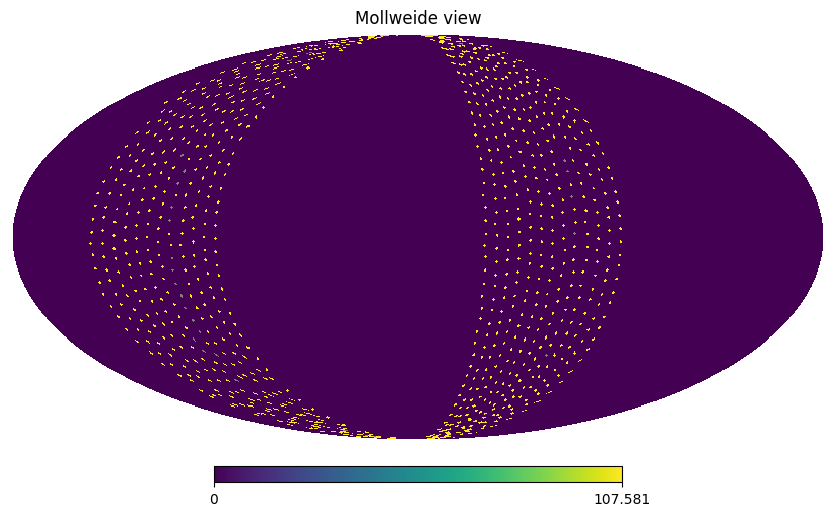

In [25]:
plt.figure()
plt.plot(loss_arr)
plt.show()

hp.mollview(found_beam[0,:])
hp.mollview(found_beam[1,:])
hp.mollview(found_beam[2,:])

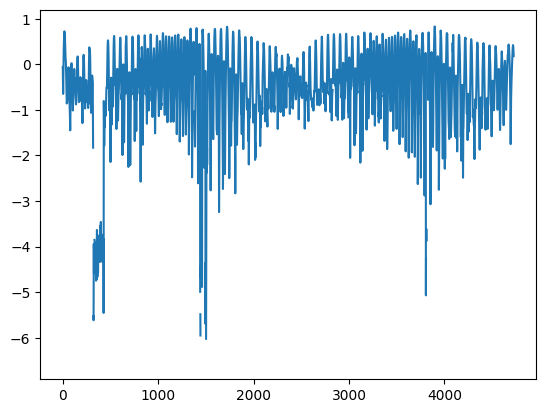

In [26]:
plt.figure()
plt.plot(Power)
plt.show()

In [701]:
plt.close('all')

## Chat Ideas

In [270]:
import numpy as np

def normalize(v):
    n = np.linalg.norm(v)
    return v if n == 0 else v/n

def R_from_azel(az, el, roll=0.0, deg=True):
    if deg:
        az  = np.deg2rad(az)
        el  = np.deg2rad(el)
        roll = np.deg2rad(roll)
    # boresight in world (z_B in W)
    zB_W = np.array([np.cos(el)*np.cos(az),
                     np.cos(el)*np.sin(az),
                     np.sin(el)])
    zB_W = normalize(zB_W)
    # pick a non-collinear world reference (here z_W); fall back to x_W if needed
    ref = np.array([0.0, 0.0, 1.0])
    if abs(np.dot(ref, zB_W)) > 0.999:  # almost parallel
        ref = np.array([1.0, 0.0, 0.0])
    # provisional x-axis: projection of ref onto plane ⟂ zB_W
    x_star = normalize(ref - np.dot(ref, zB_W)*zB_W)
    # rotate x_star about zB_W by 'roll' to get x_B in world
    xB_W = np.cos(roll)*x_star + np.sin(roll)*np.cross(zB_W, x_star)
    xB_W = normalize(xB_W)
    # y_B in world by right-hand rule
    yB_W = np.cross(zB_W, xB_W)
    # rotation matrix mapping bowtie -> world
    R_WB = np.column_stack([xB_W, yB_W, zB_W])
    return R_WB

Rwb = R_from_azel(-np.pi/2, -np.pi/2, deg=False)
print(Rwb.shape, E_copy.shape)
vb = Rwb.T@E_copy[:,top]

(3, 3) (2, 49152)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)

In [273]:
import numpy as np
import healpy as hp

def sph_to_cart(theta, phi):
    return np.array([np.sin(theta)*np.cos(phi),
                     np.sin(theta)*np.sin(phi),
                     np.cos(theta)])

def cart_to_sph(v):
    v = v/np.linalg.norm(v)
    theta = np.arccos(np.clip(v[2], -1.0, 1.0))
    phi = np.mod(np.arctan2(v[1], v[0]), 2*np.pi)
    return theta, phi

def R_from_azel(az, el, roll=0.0, deg=True):
    # Bowtie -> World: columns are bowtie axes expressed in World coords
    if deg:
        az=np.deg2rad(az); el=np.deg2rad(el); roll=np.deg2rad(roll)
    # boresight (z_B) in World
    zB = np.array([np.cos(el)*np.cos(az), np.cos(el)*np.sin(az), np.sin(el)])
    zB /= np.linalg.norm(zB)
    # pick a world reference not collinear with zB
    ref = np.array([0,0,1]) if abs(zB[2])<0.999 else np.array([1,0,0])
    # provisional x on plane ⟂ zB
    x_star = ref - (ref @ zB)*zB
    x_star /= np.linalg.norm(x_star)
    # apply roll about zB
    xB = np.cos(roll)*x_star + np.sin(roll)*np.cross(zB, x_star)
    xB /= np.linalg.norm(xB)
    yB = np.cross(zB, xB)
    return np.column_stack([xB, yB, zB])  # 3x3

def probed_bowtie_pixel(nside, az, el, theta_src, phi_src, roll=0.0, use_antipode=True):
    R_WB = R_from_azel(az, el, roll=roll, deg=True)     # 3x3
    vW = sph_to_cart(theta_src, phi_src)                # 3
    if use_antipode: vW = -vW                           # receive direction
    vB = R_WB.T @ vW                                    # 3
    thp, php = cart_to_sph(vB)
    pix = hp.ang2pix(nside, thp, php)
    return thp, php, pix

def tangent_basis(theta, phi):
    e_th = np.array([np.cos(theta)*np.cos(phi),
                     np.cos(theta)*np.sin(phi),
                     -np.sin(theta)])
    e_ph = np.array([-np.sin(phi), np.cos(phi), 0.0])
    return e_th, e_ph

def Bmat(theta, phi):
    e_th, e_ph = tangent_basis(theta, phi)
    return np.column_stack([e_th, e_ph])  # 3x2

def rotate_field_components(E_th, E_ph, theta_src, phi_src, az, el, roll=0.0, use_antipode=True):
    R_WB = R_from_azel(az, el, roll=roll, deg=True)  # 3x3
    # Direction to source in world
    vW = sph_to_cart(theta_src, phi_src)
    if use_antipode: vW = -vW
    # Arrival direction in bowtie frame
    vB = R_WB.T @ vW                                # 3
    thp, php = cart_to_sph(vB)
    # Build the 2x2 geometric Jones matrix
    B_src = Bmat(theta_src, phi_src)                # 3x2
    B_dst = Bmat(thp, php)                          # 3x2
    M = B_dst.T @ (R_WB.T @ B_src)                  # (2x3)@(3x2) -> 2x2
    Ein = np.array([E_th, E_ph])                    # 2
    Eout = M @ Ein                                  # 2  -> (E'_theta, E'_phi)
    return thp, php, Eout, M                        # angles in bowtie frame, rotated field


probed_bowtie_pixel(nside, np.pi/4, np.pi/4, np.pi/2, 0)

(3.1222072232655655, 5.497740166476182, 49151)

step 0, loss 8.998156547546387
step 100, loss 8.685718536376953
step 200, loss 7.645879745483398
step 300, loss 6.05010461807251
step 400, loss 4.249884605407715
step 500, loss 2.6012096405029297
step 600, loss 1.354064702987671
step 700, loss 0.5842676162719727
step 800, loss 0.20498213171958923
step 900, loss 0.0581778846681118
step 999, loss 0.013699940405786037


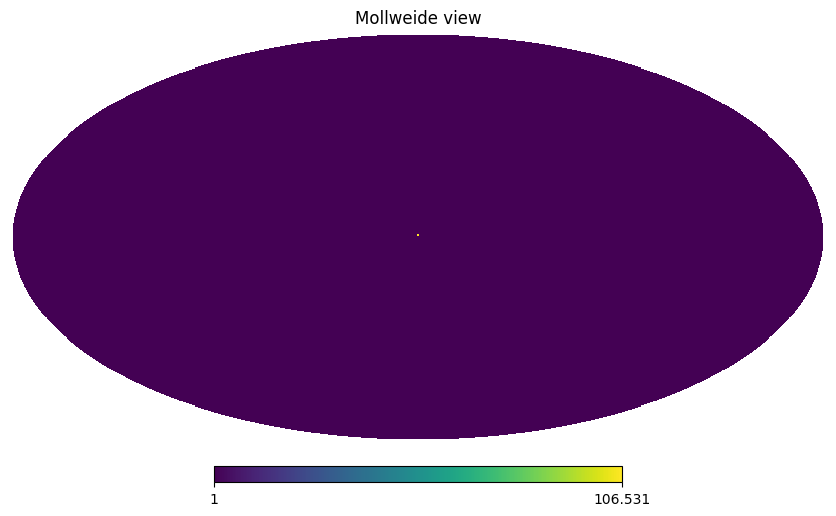

In [264]:
import jax
import jax.numpy as jnp
import optax

adam = optax.adam(1e-1)
V_const = 3  # set this once before training

def loss(A):
    pred = vis(A, E_copy)
    return jnp.mean((pred - V_const) ** 2)

@jax.jit
def update(A, opt_state):
    grads = jax.grad(loss)(A)
    updates, new_opt_state = adam.update(grads, opt_state, params=A)
    new_A = optax.apply_updates(A, updates)
    return new_A, new_opt_state


# -------------------------------------------------------------------

def solve_for_A( A_init, num_steps=1000, log_every=100):
    """Run Adam to minimize loss(A, V) over A, starting from A_init."""
    opt_state = adam.init(A_init)
    A = A_init

    # (optional) jitted loss for fast logging
    loss_jit = jax.jit(loss)

    for step in range(num_steps):
        A, opt_state = update(A, opt_state)

        if (step % log_every == 0) or (step == num_steps - 1):
            l = loss_jit(A)
            # jax.debug.print logs from device without a host round-trip
            jax.debug.print("step {s}, loss {l}", s=step, l=l)

    return A

solved = solve_for_A(jnp.array(beam_map))


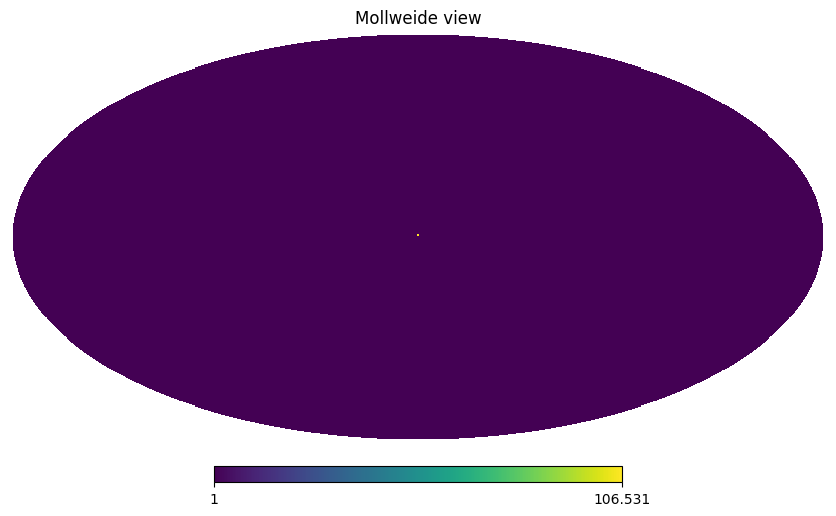

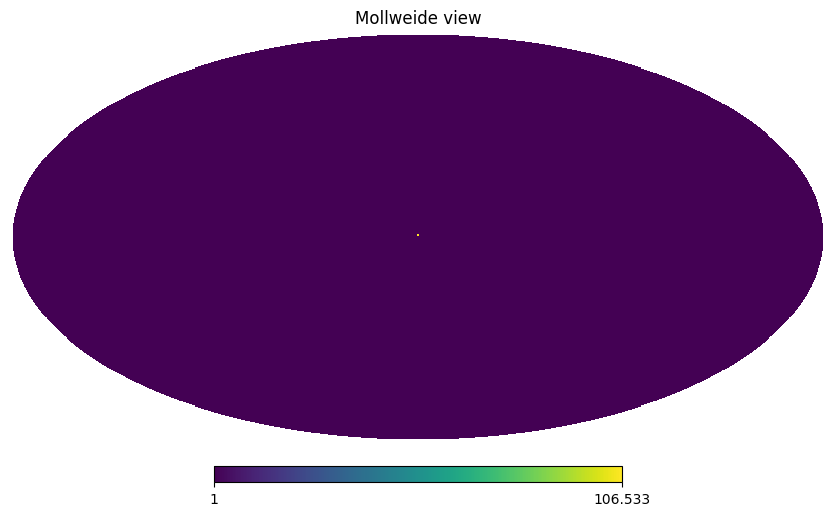

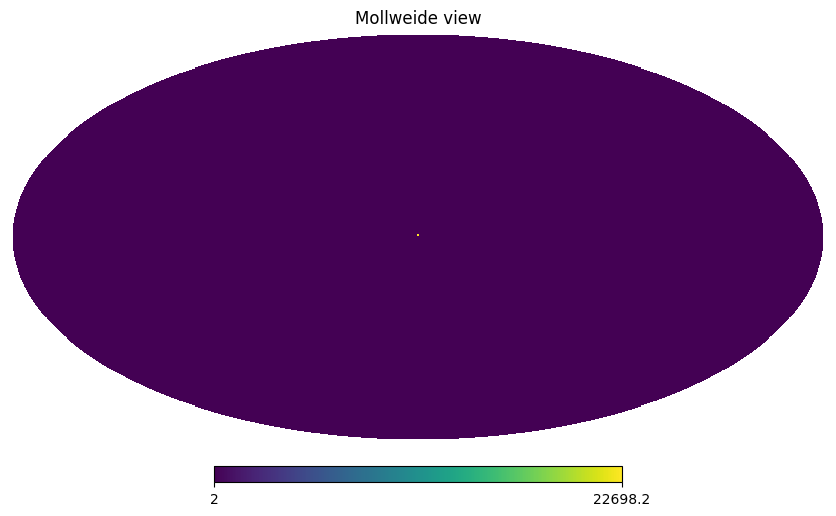

In [266]:
hp.mollview(solved[0,:])
hp.mollview(solved[1,:])
hp.mollview(np.abs(solved[1,:])**2 + np.abs(solved[0,:])**2)

In [215]:
R_mat(yaw=np.pi, pitch=np.pi, roll=0).shape, E_tx.shape

((3, 3), (2, 49152))